In [1]:
# code to reproduce results for the manuscript to C&G
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, r2_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
import os 

from dm_utils import DBMbuilder, DBMsearch
from ssnp2 import SSNP

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load data

In [3]:
df = pd.read_csv('data/PyTE.csv')
y = df['type']

features_mannual = ['Co', 'Ni', 'Cu', 'Zn', 'Se', 'As',  'Ag', 'Sb', 'Au', 'Bi', 'Pb']
X = df[features_mannual].copy().astype(float)
# group = df['group']
# Ni-Cu/PGE to Ni-Cu-PGE
y[y == 'Ni-Cu/PGE'] = 'Ni-Cu-PGE'
y[y == 'VMS'] = 'VHMS'
# X = df.copy().drop(['type', 'reference'], axis=1)
features = X.columns

C:\Users\yuwan\AppData\Local\Temp\ipykernel_13396\2812443781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'Ni-Cu/PGE'] = 'Ni-Cu-PGE'
C:\Users\yuwan\AppData\Local\Temp\ipykernel_13396\2812443781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'VMS'] = 'VHMS'


# Data preprocessing

In [4]:
scaler0 = MinMaxScaler()
X = np.log10(X+1)
X = scaler0.fit_transform(X)

print(len(y))
y.value_counts()

3594


sedimentary    1421
porphyry        658
Orogenic        615
Carlin          487
Ni-Cu-PGE       263
VHMS            150
Name: type, dtype: int64

In [5]:
## train test split
le = LabelEncoder()
y = le.fit_transform(y)


cv = StratifiedShuffleSplit(test_size=0.2,  random_state=363)
train_ind, test_ind = next(cv.split(X=X, y=y))
X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]


In [6]:
## over sampling
sampler = SMOTE(random_state=0)
X_over, y_over = sampler.fit_resample(X_train, y_train)

# SDBM/SSNP training

In [7]:
ssnp = SSNP(epochs=100, patience=5, bottleneck_activation='linear')
 
history = ssnp.fit(X_over, y_over, 0.05)
# print(history.history)
X_ssnp = ssnp.transform(X_over)
scaler2d = MinMaxScaler()
scaler2d.fit(X_ssnp)


Epoch 1/100
13/13 [==============================] - 1s 33ms/step - loss: 4.0744 - main_output_loss: 1.7193 - decoder_output_loss: 0.6771 - main_output_accuracy: 0.1758 - decoder_output_accuracy: 0.3133 - val_loss: 4.3441 - val_main_output_loss: 2.1083 - val_decoder_output_loss: 0.6451 - val_main_output_accuracy: 0.0000e+00 - val_decoder_output_accuracy: 0.0994
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 3.5233 - main_output_loss: 1.3494 - decoder_output_loss: 0.6502 - main_output_accuracy: 0.4705 - decoder_output_accuracy: 0.3785 - val_loss: 3.9378 - val_main_output_loss: 1.9288 - val_decoder_output_loss: 0.5648 - val_main_output_accuracy: 0.0000e+00 - val_decoder_output_accuracy: 0.3947
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 2.9417 - main_output_loss: 0.9619 - decoder_output_loss: 0.5964 - main_output_accuracy: 0.5985 - decoder_output_accuracy: 0.5247 - val_loss: 2.9954 - val_main_output_loss: 1.2190 - val_decoder_outpu

MinMaxScaler()

# Search for the best classifiers

In [8]:
models = [
LogisticRegression(random_state=0),
SVC(probability=True),
RandomForestClassifier(random_state=0, n_jobs=-1),
# XGBClassifier(verbosity=0),
MLPClassifier(random_state=0) #, max_iter=500, early_stopping=True, hidden_layer_sizes=(64,64,64)
]

cv = StratifiedShuffleSplit(test_size=0.2,  random_state=363)
cv = StratifiedKFold()

mysearch = DBMsearch(models, ssnp, X=X_over, y=y_over, cv=cv)

In [9]:
 mysearch.search()

searching model: LogisticRegression(random_state=0)
 1/43 [..............................] - ETA: 2s

c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


43/43 [==============================] - ETA: 0s

c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


43/43 [==============================] - 0s 1ms/step
searching model: SVC(probability=True)


c:\Users\yuwan\workspace\SDBM_for_Pyrite\dm_utils.py:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append({'model': model, 'classifier accucarcy': clf_acc.mean(),  "DBM accucarcy": dbm_acc.mean(), 'consistancy': projection_miss.mean()}, ignore_index=True)


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\workspace\SDBM_for_Pyrite\dm_utils.py:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append({'model': model, 'classifier accucarcy': clf_acc.mean(),  "DBM accucarcy": dbm_acc.mean(), 'consistancy': projection_miss.mean()}, ignore_index=True)


searching model: RandomForestClassifier(n_jobs=-1, random_state=0)
43/43 [==============================] - 0s 1ms/step
searching model: MLPClassifier(random_state=0)


c:\Users\yuwan\workspace\SDBM_for_Pyrite\dm_utils.py:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append({'model': model, 'classifier accucarcy': clf_acc.mean(),  "DBM accucarcy": dbm_acc.mean(), 'consistancy': projection_miss.mean()}, ignore_index=True)


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 1/43 [..............................] - ETA: 0s

c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


43/43 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 1/43 [..............................] - ETA: 0s

c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 1/43 [..............................] - ETA: 1s

c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


43/43 [==============================] - 0s 1ms/step
                                               model  classifier accucarcy  \
0                 LogisticRegression(random_state=0)              0.855176   
1                              SVC(probability=True)              0.942248   
2  (DecisionTreeClassifier(max_features='sqrt', r...              0.984317   
3                      MLPClassifier(random_state=0)              0.938878   

   DBM accucarcy  consistancy  
0       0.916158     0.871887  
1       0.923779     0.921434  
2       0.890649     0.890796  
3       0.920995     0.919529  
best model: SVC(probability=True)


c:\Users\yuwan\workspace\SDBM_for_Pyrite\dm_utils.py:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append({'model': model, 'classifier accucarcy': clf_acc.mean(),  "DBM accucarcy": dbm_acc.mean(), 'consistancy': projection_miss.mean()}, ignore_index=True)


SVC(probability=True)

In [10]:
mysearch.results

,model,classifier accucarcy,DBM accucarcy,consistancy
0,LogisticRegression(random_state=0),0.855176,0.916158,0.871887
1,SVC(probability=True),0.942248,0.923779,0.921434
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.984317,0.890649,0.890796
3,MLPClassifier(random_state=0),0.938878,0.920995,0.919529


# Map building

In [11]:
# retrain the best model
clf = SVC(probability=True)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = le.inverse_transform(y_pred)
y_test_ori = le.inverse_transform(y_test)
print(classification_report(y_test_ori, y_pred))


              precision    recall  f1-score   support

      Carlin       0.95      0.87      0.91        97
   Ni-Cu-PGE       0.96      0.83      0.89        53
    Orogenic       0.83      0.77      0.80       123
        VHMS       0.90      0.90      0.90        30
    porphyry       0.84      0.92      0.88       132
 sedimentary       0.95      0.99      0.97       284

    accuracy                           0.91       719
   macro avg       0.90      0.88      0.89       719
weighted avg       0.91      0.91      0.91       719



In [12]:
def mine_cm(y_true, y_pred, le, ax=None, cbar=True):
    labels = le.classes_.copy()
    # capitalize labels for the last 2
    labels[-2:] = [label.capitalize() for label in labels[-2:]]
    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), index=labels, columns=labels)
    if not ax:
        fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='YlGn', vmax=90, center=44, cbar=cbar, square=False)
    # ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    for item in ax.get_xticklabels():
        item.set_rotation(90)


def plot_letter(axes):
    ##plot lower case letter at the top left corner of each subplot
    for i, ax in enumerate(axes):
        ax.text(-0.1, 1.1, chr(97+i), fontsize=8)

23/23 [==============================] - 0s 1ms/step


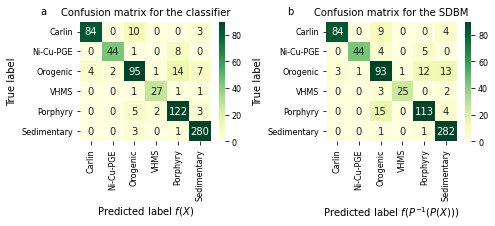

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.3), sharex=False)
mine_cm(y_test, clf.predict(X_test), le, ax=ax1, cbar=True)


mine_cm(y_test, clf.predict(ssnp.inverse_transform(ssnp.transform(X_test))), le, ax=ax2)
ax1.set_title('Confusion matrix for the classifier')
ax2.set_title('Confusion matrix for the SDBM')

ax1.set_xlabel(r'Predicted label $f (X)$')

ax2.set_xlabel(r'Predicted label $f (P^{-1}(P(X)))$')

for i, ax in enumerate([ax1, ax2]):
    ax.text(-0.3, 1.06, chr(97+i), fontsize=10. , transform=ax.transAxes)
###  predicted f(X) | f(P-1P(X))
plt.tight_layout()
# fig.savefig('./figures/fig_2_confusion_matrix.png', bbox_inches='tight')

In [14]:
### plot labels for each zone for clarity
def plot_labels(ax, fontsize=7):
    ax.text(0.5, 0.1, 'Carlin', fontsize=fontsize)
    ax.text(0.1, 0.37, 'Orogenic', fontsize=fontsize)
    ax.text(0.01, 0.64, 'Porphyry', fontsize=fontsize)
    ax.text(0.7, 0.58, 'VMS', fontsize=fontsize)
    ax.text(0.59, 0.41, 'Sedimentary', fontsize=fontsize)
    ax.text(0.37, 0.9, 'Ni-Cu/PGE', fontsize=fontsize)
    return ax

23/23 [==============================] - 0s 1ms/step


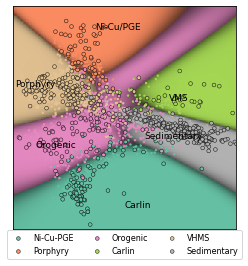

In [15]:
builder = DBMbuilder(clf, ssnp, scaler2d=scaler2d, scalernd=scaler0)

hue_order = le.classes_
## manual adjust the order of the labels
hue_order = ['Ni-Cu-PGE', 'porphyry', 'Orogenic', 'Carlin', 'VHMS', 'sedimentary' ]

ax = builder.plot_prob_map(cmap=cm.Set2)

X_2d_train = scaler2d.transform(ssnp.transform(X_train))
X_2d_test = scaler2d.transform(ssnp.transform(X_test))

cmap = cm.Set2
colors = cmap(np.linspace(0, 1, len(hue_order)))

#############################################
for i, label in enumerate(hue_order):
    tem_train_ind = y_train == i
    tem_test_ind = y_test == i
    ax.scatter(X_2d_train[tem_train_ind, 0], X_2d_train[tem_train_ind, 1], c=[colors[i]]*sum(tem_train_ind), s=2, alpha=0.88)
    if i == 1 or i == 5:
        ax.scatter(X_2d_test[tem_test_ind, 0], X_2d_test[tem_test_ind, 1], c=[colors[i]]*sum(tem_test_ind), alpha=0.95, edgecolors='#090909', s=14, linewidths=0.5, label=label.capitalize())
    else:
        ax.scatter(X_2d_test[tem_test_ind, 0], X_2d_test[tem_test_ind, 1], c=[colors[i]]*sum(tem_test_ind), alpha=0.95, edgecolors='#090909', s=14, linewidths=0.5, label=label)
###################################################

### set aspect ratio 1:1
ax.set_aspect('equal')
plot_labels(ax, 9)
#### figure size
ax.figure.set_size_inches(4.1, 4.1)
## legends outside the plot, below the ax
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=3)
#save figure
# plt.savefig('./figures/dbm_2d.png', dpi=300, bbox_inches='tight')


# Application 1: Feature inverse projection

In [16]:
# permutation importance
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=np.array(features)[sorted_importances_idx],
)

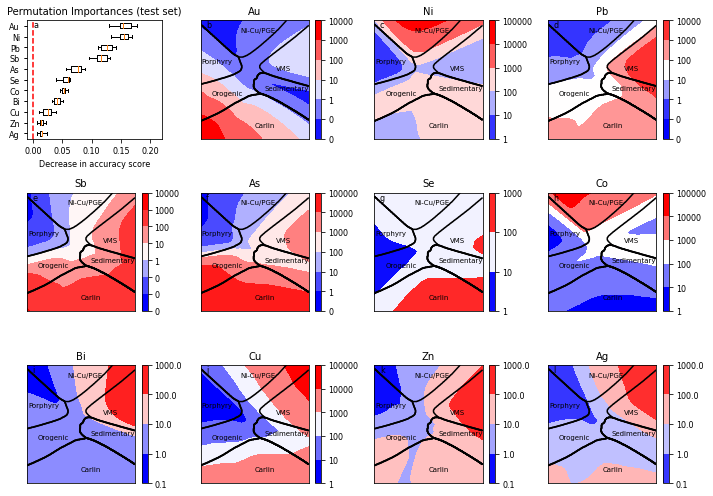

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(10,7))

ax = axes.flatten()[0]
##################################
### plot permutation importance

ax = importances.plot.box(vert=False, whis=10, ax=ax)
ax.boxplot(importances.values, vert=False, whis=10, labels=importances.columns)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="r", linestyle="--")
ax.set_xlabel("Decrease in accuracy score", fontsize=8)
ax.set_xlim(-0.01, 0.22)

##############################horizontal box plot
# ax.boxplot(importances.values, vert=True, whis=10, labels=importances.columns)
# ax.set_title("Permutation Importances (test set)")
# ax.axhline(y=0, color="r", linestyle="--")
# ax.set_ylabel("Decrease in accuracy score")
# ## invert x axis
# ax.invert_xaxis()
##############################

for i, ax in zip(sorted_importances_idx[::-1], axes.flatten()[1:]):
    ax = builder.plot_inversed_feature(i, feature_names=features, ax=ax, countour=True)
    plot_labels(ax, 7)


for ax in axes.flatten():
    # plot lower case letter at the top left corner of each subplot
    ax.text(0.05, 0.94, chr(97+axes.flatten().tolist().index(ax)), fontsize=8, transform=ax.transAxes)
    

plt.tight_layout()
# fig.savefig('figures/trained_features.png', dpi=300)

# Application 2: data from new location (Zaozigou deposit)

In [18]:
## save mean of each feature in train set
df_train = df.loc[train_ind, features]
df_train_mean = df_train.mean()
SVM_table = pd.DataFrame(columns=['Ni-Cu-PGE', 'porphyry', 'Orogenic', 'Carlin', 'VHMS', 'sedimentary'])
SDBM_table = pd.DataFrame(columns=['Ni-Cu-PGE', 'porphyry', 'Orogenic', 'Carlin', 'VHMS', 'sedimentary'])

def plot_custom_data(path, hue=None, marker=None, ax=None, **kwargs):
    if type(path) == str:
        # cols = features + [hue] + [marker]
        
        demo = pd.read_excel(path)#[cols].dropna()
        # check if every feature is in demo, if not, fillna with mean of train set
        for fea in features:
            if fea not in demo.columns:
                print(fea, 'not in the data, fillna with mean of train set')
                demo[fea] = df_train_mean[fea]
    else:
        demo = path
    demo_X = scaler0.transform(np.log10(demo[features]+1))

    ## drop nan
    n_ind = ~np.isnan(demo_X).any(axis=1)
    demo_X = demo_X[n_ind]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    color = demo[hue]
    color = color[n_ind]
    marker = demo[marker]
    marker = marker[n_ind]
    ##############################
    xticks = le.classes_
    for i in ['Py1a', 'Py1b', 'Py2']:
        print(i)
        ind = (color == i)
        # chech is ind is empty
        if ind.sum() == 0:
            continue
        # predict label via clf 
        demo_y = clf.predict(demo_X[ind])
        # inverse transform label
        demo_y = le.inverse_transform(demo_y)
        demo_y_DBM = clf.predict(ssnp.inverse_transform(ssnp.transform(demo_X[ind])))
        demo_y_DBM = le.inverse_transform(demo_y_DBM)
        # print count of each label
        res_DBM = pd.Series(demo_y_DBM).value_counts()
        res_SVM = pd.Series(demo_y).value_counts()
        for key, item in res_DBM.items():
            # print(key, item)
            SDBM_table.loc[i, key] = item
        for key, item in res_SVM.items():
            # print(key, item)
            SVM_table.loc[i, key] = item


    # demo_ssnp = ssnp.transform(demo_X)
    demo_2d = builder.transform(demo_X)
    y_pred = le.inverse_transform(clf.predict(demo_X))
    y_pred_DBM = le.inverse_transform(clf.predict(ssnp.inverse_transform(scaler2d.inverse_transform(demo_2d))))
    res_DBM = pd.Series(y_pred_DBM).value_counts()
    res_SVM = pd.Series(y_pred).value_counts()
    for key, item in res_SVM.items():
        # print(key, item)
        SVM_table.loc['Total', key] = item
    for key, item in res_DBM.items():
        # print(key, item)
        SDBM_table.loc['Total', key] = item


    builder.plot_prob_map(ax=ax, cmap=cm.Set2)
    # ax.set_facecolor('black')
    sns.scatterplot(demo_2d[:, 0], demo_2d[:, 1], hue=color, ax=ax, style=color, edgecolor='k', **kwargs)
    # kearnel density estimation
    # sns.kdeplot(demo_2d[:, 0], demo_2d[:, 1], ax=ax, shade=False, alpha=0.8, hue=color, legend=False, levels=3)
        
    ax.set(xlim=(0, 1), ylim=(0, 1))

    plot_labels(ax, 9)

Py1a
2/2 [==============================] - 0s 3ms/step
Py1b
1/1 [==============================] - 0s 46ms/step
Py2
4/4 [==============================] - 0s 1ms/step


c:\Users\yuwan\scoop\apps\python\current\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


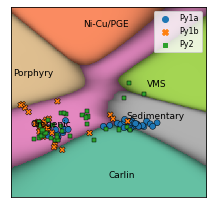

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
zzg_path = './data/zzg2.xlsx'
plot_custom_data(zzg_path, hue='Type', marker='Type', ax=ax)

### legend upper right
handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0))

# plt.savefig('./figures/zzg_log.png', dpi=300)

In [20]:
SVM_table = SVM_table.fillna(0)
SDBM_table = SDBM_table.fillna(0)

for i in range(SVM_table.shape[0]):
    row_total = SVM_table.iloc[i, :].sum()
    for col in range(SVM_table.shape[1]):
        orig_value = SVM_table.iloc[i, col]
        SVM_table.iloc[i, col] = f'{orig_value} ({orig_value/row_total:.2%})'

for i in range(SDBM_table.shape[0]):
    row_total = SDBM_table.iloc[i, :].sum()
    for col in range(SDBM_table.shape[1]):
        orig_value = SDBM_table.iloc[i, col]
        SDBM_table.iloc[i, col] = f'{orig_value} ({orig_value/row_total:.2%})'

In [21]:
SVM_table

,Ni-Cu-PGE,porphyry,Orogenic,Carlin,VHMS,sedimentary
Py1a,0 (0.00%),0 (0.00%),20 (48.78%),17 (41.46%),0 (0.00%),4 (9.76%)
Py1b,0 (0.00%),0 (0.00%),30 (93.75%),2 (6.25%),0 (0.00%),0 (0.00%)
Py2,0 (0.00%),1 (2.70%),28 (75.68%),7 (18.92%),0 (0.00%),1 (2.70%)
Total,0 (0.00%),1 (0.91%),78 (70.91%),26 (23.64%),0 (0.00%),5 (4.55%)


In [22]:
SDBM_table

,Ni-Cu-PGE,porphyry,Orogenic,Carlin,VHMS,sedimentary
Py1a,0 (0.00%),0 (0.00%),15 (36.59%),1 (2.44%),0 (0.00%),25 (60.98%)
Py1b,0 (0.00%),2 (6.25%),25 (78.12%),2 (6.25%),0 (0.00%),3 (9.38%)
Py2,0 (0.00%),0 (0.00%),29 (78.38%),3 (8.11%),2 (5.41%),3 (8.11%)
Total,0 (0.00%),2 (1.82%),69 (62.73%),6 (5.45%),2 (1.82%),31 (28.18%)
